# Проект телекоммуникации

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Таким образом, нам необходимо на основании предоставленных исторических данных о поведении клиентов и расторжении договоров с оператором спрогнозировать, уйдёт клиент от оператора в ближайшее время или нет.

### Описание услуг

Оператор предоставляет два основных типа услуг:

 1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
 2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

 * Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
 * Выделенная линия технической поддержки (TechSupport);
 * Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
 * Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


### Описание данных

Данные состоят из файлов, полученных из разных источников:

 * contract_new.csv — информация о договоре;
 * personal_new.csv — персональные данные клиента;
 * internet_new.csv — информация об интернет-услугах;
 * phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

**Данные**

 * BeginDate - дата начала пользования услугами
 * EndDate - дата окончания пользования услугами
 * Type - тип оплаты (ежемесячный, годовой и т.д.)
 * PaperlessBilling - электронный платежный документ
 * PaymentMethod - способ оплаты
 * MonthlyCharges - ежемесячные траты по договору
 * TotalCharges - всего потрачено денег на услуги
 * Dependents - наличие иждивенцев
 * Senior Citizens - наличие пенсионного статуса по возрасту
 * Partner - наличие супруга(-и)
 * MultiplyLines - наличие возможности ведения параллельных линий во время звонка


### Вывод

**Основная цель проекта** - разработать модель для решения задачи классификации, позволяющая при заданной точности AUC-ROC не менее 0.85 прогнозировать уход клиента (для реализации возможности дальнейшего его удержания с помощью промокодов и специальных условий).

Для достижения цели необходимо будет проделать следующие шаги.

**Задачи проекта:**

 - подготовка данных (импорт библиотек, осмотр данных, первичная предобработка)
 - исследование данных (исследовательский анализ, подготовка признаков)
 - моделирование (построение моделей и тестирование лучшей)

**Условия выполнения и технические детали:**

Дополнительно считаем и интерпретируем метрику Accuracy для отчета. Для моделирования:
 * в качестве константы берем RANDOM_STATE = 140823
 * корреляцию категориальных признаков исследуем при помощи библиотеки phik с настройкой interval_cols
 * соотношение train/test = 3:1
 * оценку важности признаков лучшей модели производим на линейных моделях через веса признаков; для дерева решений, случ.леса и бустинга посредством атрибута feature_importance_; для любых других моделей - через бибиотеку SHAP
 * утечка целевого признака д.б. меньше 0.95
 * не используем get_dummies() и PandasProfiling

## Подготовка данных


### Импорт данных и библиотек

In [ ]:
!pip install phik
#!pip install shap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import phik
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, train as trainLGBM
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from joblib import dump, load
#import shap

In [ ]:
contract = pd.read_csv(
    '/datasets/contract_new.csv',
    index_col='customerID',
    parse_dates=['BeginDate', 'EndDate']
)
personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

In [ ]:
for i in (contract, personal, internet, phone):
    display(i.head())
    i.info()
    display(i.isna().sum())
    display(i.duplicated().sum())

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

37

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

7027

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

5389

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


MultipleLines    0
dtype: int64

6359

Рассмотрим детальнее таблицы: посмотрим на уникальные значения категориальных признаков

In [ ]:
for i in contract.select_dtypes(include='object').columns.to_list():
#('EndDate','Type','PaperlessBilling','PaymentMethod','TotalCharges'):
    print(contract[i].value_counts(),'\n')

for table in (personal, internet, phone):
    for i in table.columns.to_list():
        print(table[i].value_counts(),'\n')
        plt.show()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-09-01       2
2014-11-01       1
2014-06-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64 

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64 

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64 

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64 

           11
20.45       6
101.0       5
21.53       4
1007.5      4
           ..
4989.63     1
3091.7      1
5745.9      1
393.12      1
8998.27     1
Name: TotalCharges, Length: 6658, dtype: int64 

Male      3555
Female    3488
Name: gender, dtype: int64 

0    5901
1    1142
Name: SeniorCitizen, dtype: int64 

No     3641
Yes    3402
Name: Partner, dtype: int64 

No     4933
Yes    2110
Name: Dependents, dtyp

**Предварительные выводы**:

Данные из всех четырех таблиц **не содержат явных дубликатов и пропусков**. Общий столбец для всех - customerID, выступающий уникальным ключом (его значения сразу преобразовали в индексы).

Почти все колонки строкового типа, кроме MonthlyCharges из таблицы договоров (float64) и SeniorCitizen из персональных данных (int64); эти таблицы содержат по 7043 записи (в 8 колонках для договоров и 5 для персональных данных).

Таблица интернет-услуг содержит 5517 записей в 8 колонках строкового типа, таблица с услугами телефонии - 6361 объект в 2 строковых столбцах.

Большинство признаков имеет два уникальных значения.

Значение 'No' в дате окончания действия услуги EndDate означает, что клиент продолжает пользоваться услугой.

В столбце TotalCharges имеются пустые значения, не являющиеся пропусками.

**Для дальнейшего анализа необходимо**

 * Тип столбца TotalCharges изменить на вещественный (заменить пустые значения).

 * Целевой категориальный признак создать на основании столбца EndDate. Самому столбцу также поменять тип (наряду с BeginDate), предварительно поменяв "заглушку" 'No' на дату актуальности информации. На основании этих двух столбцов создать новый признак - длительность пользования услугами оператора

 * Привести название столбца gender к единому формату с остальными

 * Объединить данные в одну таблицу и исследовать ее

In [ ]:
# константы
RANDOM_STATE = 140823
AUCROC_MIN = 0.85
LEAK = 0.95

### Первичная предобработка

#### Объединение таблиц

Для дальнейшей работы с данными мы сперва объединим таблицы в одну с помощью join() по индексам, в качестве которых выступают значения столбца customerID.

In [ ]:
data = contract.join(personal)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 918.3+ KB


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No


Данные с персональной информацией и договорами содержат одинаковые индексы, поэтому количество строк новой таблицы содержит ровно столько же записей, сколько и в исходных этих двух таблицах - 7043 (количество столбцов новой таблицы 11=4+7). Далее поочередно присоединим таблицы с услугами, попутно заменяя возникающие пропуски в соответствующих столбцах на значение по умолчанию (для  интернет-услуг это будет 'no_internet', для телефонии - 'no_phone') и проверяя общее количество строк и столбцов.

In [ ]:
data = data.join(internet).fillna('no_internet')
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,
9609-BENEA,2017-03-01,No,One year,Yes,Electronic check,69.00,2511.6,Male,0,Yes,No,DSL,No,Yes,No,Yes,Yes,No
7683-CBDKJ,2018-09-01,No,Month-to-month,Yes,Electronic check,65.45,1212.79,Male,0,Yes,Yes,DSL,Yes,Yes,No,No,Yes,No
3703-VAVCL,2019-08-01,No,Month-to-month,No,Credit card (automatic),90.00,550.8,Male,0,Yes,Yes,Fiber optic,No,No,Yes,Yes,No,Yes
1498-DQNRX,2017-09-01,No,Month-to-month,No,Mailed check,19.85,621.7,Female,0,Yes,No,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet
0327-WFZSY,2016-11-01,2018-06-01,One year,No,Electronic check,100.00,1900.0,Male,0,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes


In [ ]:
data = data.join(phone).fillna('no_phone')
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
4942-VZZOM,2014-10-01,No,One year,Yes,Credit card (automatic),66.15,4233.6,Male,0,Yes,No,DSL,Yes,No,No,No,Yes,No,Yes
6732-FZUGP,2016-03-01,No,One year,No,Credit card (automatic),94.90,4906.33,Female,0,No,No,Fiber optic,Yes,No,Yes,No,Yes,No,Yes
9554-DFKIC,2017-08-01,No,Month-to-month,Yes,Bank transfer (automatic),54.45,1731.51,Male,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes
3936-QQFLL,2019-12-01,No,Month-to-month,No,Mailed check,19.75,42.66,Male,0,No,No,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No
2926-JEJJC,2019-06-01,No,One year,Yes,Bank transfer (automatic),20.20,161.6,Female,0,No,No,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No


Таким образом, объединенная таблица содержит 7043 объекта в 19 столбцах, что соответствует исходным данным. Пропусков нет. Приступаем к дальнейшей обработке.

#### Создание целевого признака

In [ ]:
data['Exited'] = np.where(data['EndDate']=='No', 0, 1)
data.sample(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exited
customerID,,,,,,,,,,,,,,,,,,,,
6061-PQHMK,2018-01-01,No,One year,No,Credit card (automatic),19.90,497.5,Female,0,No,No,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0
7812-FZHPE,2018-06-01,No,Month-to-month,No,Mailed check,24.10,520.56,Female,0,Yes,Yes,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,Yes,0
4074-SJFFA,2019-12-01,No,Month-to-month,Yes,Mailed check,54.75,113.88,Female,0,No,No,DSL,No,No,No,No,No,Yes,No,0
6994-FGRHH,2014-04-01,No,One year,Yes,Electronic check,106.15,7430.5,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,No,0
6695-FRVEC,2014-07-01,2017-08-01,Two year,Yes,Bank transfer (automatic),60.40,2234.8,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,No,No,No,1
7567-ECMCM,2018-02-01,No,Month-to-month,Yes,Credit card (automatic),79.85,1916.4,Male,0,No,No,Fiber optic,No,No,No,No,No,Yes,No,0
8857-CUPFQ,2014-11-01,No,Two year,No,Mailed check,19.25,1309.77,Male,0,Yes,No,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0
8750-QWZAJ,2014-04-01,No,Two year,No,Bank transfer (automatic),19.80,1427.58,Female,0,Yes,Yes,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0
6166-ILMNY,2019-10-01,No,Month-to-month,No,Bank transfer (automatic),69.75,279.0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


Для клиентов, прекративших пользоваться услугами оператора, значение целевого признака равно 1, иначе - 0. Посмотрим сразу на баланс классов.

In [ ]:
# распределение долей
display(data['Exited'].value_counts(normalize=True))
# коэффициент
pd.Series(data['Exited'].value_counts(normalize=True))[0] / pd.Series(data['Exited'].value_counts(normalize=True))[1]

0    0.843675
1    0.156325
Name: Exited, dtype: float64

5.396911898274296

Численность класса продолжающих пользоваться услугами оператора клиентов более чем в 5 раз превышает численность ушедших клиентов. Имеем дело с задачей **несбалансированной классификации**. *Но прибегать к методу взвешивания классов или иных методов борьбы с дисбалансом при построении моделей мы не будем, так как целевая метрика AUC-ROC нечувствительна к дисбалансу.*

#### Создание признака дительности договора

Сначала преобразуем типы столбцов с датами

In [ ]:
# изменим типы столбцов дат начала и конца обслуживания,
# заменяя значения 'No' в EndDate на актуальную дату
data['EndDate'].loc[data['EndDate']=='No'] = '2020-02-01'
for i in ('BeginDate', 'EndDate'):
    data[i] = pd.to_datetime(data[i], format="%Y-%m-%d")
# проверим типы столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Новый признак - количество дней, в которых клиент обслуживается(-лся) у оператора:

In [ ]:
# создание нового признака
data['Tenure'] = ((data['EndDate'] - data['BeginDate'])  / np.timedelta64(1,'D')).astype('int64')
data.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exited,Tenure
customerID,,,,,,,,,,,,,,,,,,,,,
0564-MUUQK,2018-06-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),95.50,2101.0,Female,0,Yes,...,Fiber optic,No,No,Yes,Yes,No,Yes,Yes,0,610
4803-AXVYP,2016-09-01,2018-11-01,Month-to-month,Yes,Electronic check,99.55,2614.18,Female,1,No,...,Fiber optic,No,No,No,Yes,Yes,Yes,Yes,1,791
4948-WBBKL,2017-02-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),74.90,2696.4,Female,1,No,...,Fiber optic,No,No,No,No,No,No,Yes,0,1095
1820-DJFPH,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),24.05,1731.6,Female,0,Yes,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,Yes,0,2191
0578-SKVMF,2017-12-01,2020-02-01,Month-to-month,No,Electronic check,83.30,2165.8,Female,0,Yes,...,Fiber optic,No,Yes,No,No,No,Yes,No,0,792


#### Другие изменения столбцов

In [ ]:
# изменим тип столбца TotalCharges на вещественный, заменяя некорректные значения на NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
# и проверим количество пропусков в столбце
data['TotalCharges'].isna().sum()

11

In [ ]:
# выведем строки с получившимся пустым значением столбца TotalCharges
data.loc[data['TotalCharges'].isna()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exited,Tenure
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,no_phone,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,Yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,no_phone,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,Yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,0


После изменения типа столбца TotalCharges в нем образовались пропуски, которые можно объяснить следующим образом. Все такие записи относятся к контрактам, заключенным в день, соответствующий дате актуальности данных - 01.02.2020, откуда делаем вывод, что это новые контракты, по которым еще не успела накопиться фактическая итоговая задолженность. Поэтому заполним эти пропуски *значениями из столбца MonthlyCharges*.

In [ ]:
#empties = data[data['TotalCharges'].isna()].index.to_list()
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges'])
# и выведем снова количество пропусков для проверки
data['TotalCharges'].isna().sum()

0

*Для корректного отнесения столбца SeniorCitizen к числу категориальных (коим он и является), изменим его тип на object и проверим типы колонок датафрейма*

In [ ]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')
data.dtypes

BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
gender                      object
SeniorCitizen               object
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
Exited                       int64
Tenure                       int64
dtype: object

И еще один штрих. Сравняем названия столбцов в едином "верблюжьем стиле" и посмотрим на оставшиеся получившиеся названия.

In [ ]:
data = data.rename(columns={'gender': 'Gender'})
data.columns.to_list()

['BeginDate',
 'EndDate',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'Exited',
 'Tenure']

**Предварительные выводы:**

 - Таблицы объединены корректно
 - Целевой признак создан и изучен дисбаланс классов, определена задача несбалансированной классификации
 - Дополнительный признак длительности количества дней обслуживания создан
 - Изменены типы некоторых столбцов
 - Названия столбцов приведены к единому стилю

### Исследовательский анализ

Рассмотрим теперь распределения и аномалии в данных.

#### *Численные столбцы*

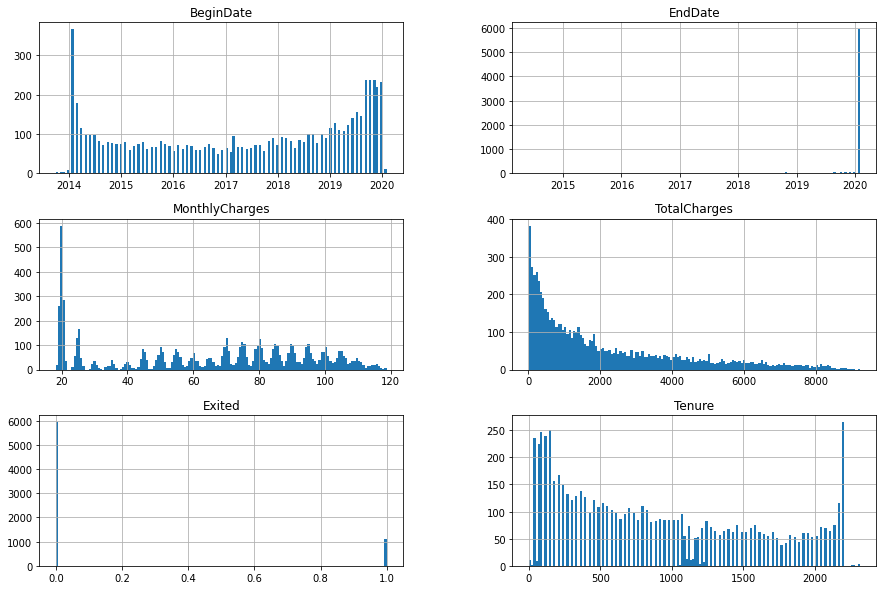

In [ ]:
data.hist(bins=150,figsize=(15,10));

**Описание:**

Признак TotalCharges имеет распределение, напоминающее пуассоновское с максимумом в нулевом значении. Большое количество значений в районе 2020 года столбца EndDate связано с заполнением значения 'No' - это незавершенные договора. В MonthlyCharges имеются заметные выбросы в районе значения 20 с локальными максимумами каждые 5 денежных единиц. Значения столбца Tenure распределены по убывающей, имея заметное возрастание количества значений после 1700 с явными выбросами на почти максимальных значениях. Распределение BeginDate практически зеркально отражает распределение Tenure, поскольку они связаны одной формулой. Категориальные столбцы SeniorCitizen и Exited выражены числовыми значениями, поэтому попали на гистограмму.

#### *Категориальные столбцы*

*Категориальные столбцы рассмотрим на круговых диаграммах:*

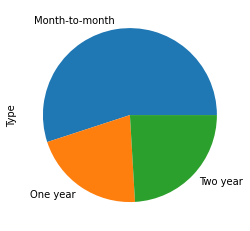

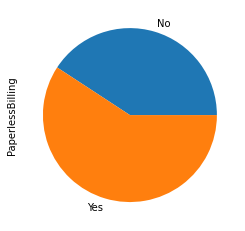

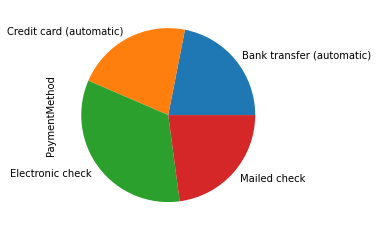

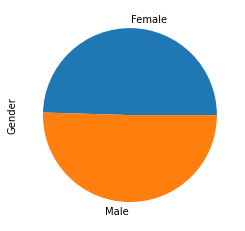

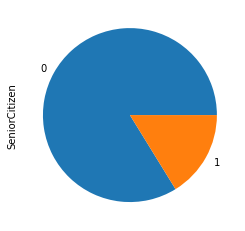

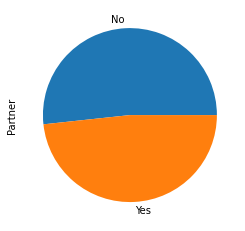

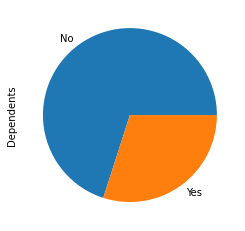

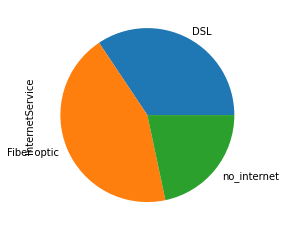

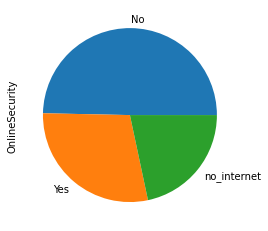

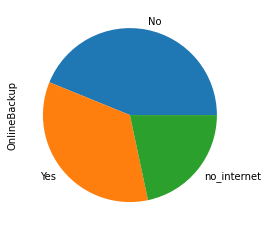

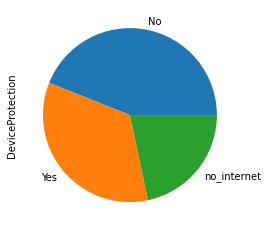

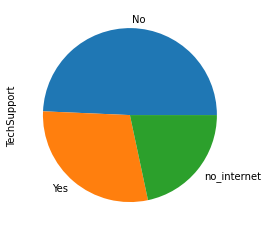

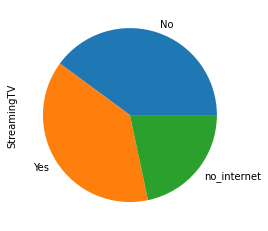

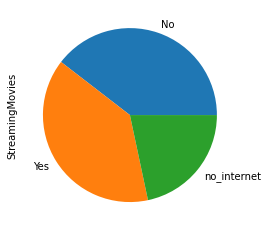

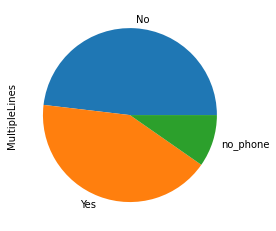

In [ ]:
for i in data.select_dtypes(include='object').columns.to_list():
    data.groupby(i)[i].count().plot(kind='pie') #sns.countplot(x=i, data=data)
    plt.show()

***Описание:***

*Тип оплаты Type преимущественно ежемесячный (более половины всех значений); из оставшихся типов годовой чуть уступает двухлетнему. Бумажный платежный документ более распространен, нежели электронный. По способу оплаты лидирует однако электронный чек, составляя более трети от общего числа значений; остальные три вида примерно оинаково предпочтительны. По половому признаку данные распределены примерно одинаково, как и по наличию партнера (чуть больше "одиночек"); а по наличию иждивенцев распределение примерно 1:2 (также больше "одиночек"). Оптоволокно предпочительнее DSL, без услуги интернета меньше четверти пользователей - эта доля клиентов сохраняется для всех интернет-услуг, различие только в соотношении классов среди пользователей интернета: самая популярная услуга StreamingMovies и StreamingTV, а также антивирус DeviceProtection и облачное хранилище файлов для резервного копирования данных OnlineBackup; не популярны в большей степени линия тех.поддержки TechSupport и блокировка небезопасных сайтов OnlineSecurity. Клиентов, пользующихся возможностью ведения параллельных линий, чуть меньше по численности с теми, кто не пользуется; без телефона до сих пор пребывает еще малая часть пользователей.*
*Пенсионеры в меньшинстве*

**Далее необходимо:**

Построить корреляционную матрицу и убрать ненужные столбцы.

#### *Корреляционная матрица*

*Сперва избавимся от ненужных столбцов: поскольку мы будем строить матрцу корреляции, искать зависимость признаков от дат вне задачи временных рядов некорректно и слишком растянуто по времени. Ну и при* построении моделей даты начала и конца обслуживания сами по себе вряд ли несут какую-то информационную пользу - добавленный из этих столбцов признак длительности обслуживания будет более информативен, поэтому удалим признаки с датами.

In [ ]:
# удаление столбцов с датами
data.drop(columns=['BeginDate', 'EndDate'], axis=1, inplace=True)
# вывод списка столбцов датафрейма
data.columns.to_list()

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'Exited',
 'Tenure']

Оставили необходимые для обучения модели столбцы в едином формате написания. *Теперь рассмотрим корреляционную карту*

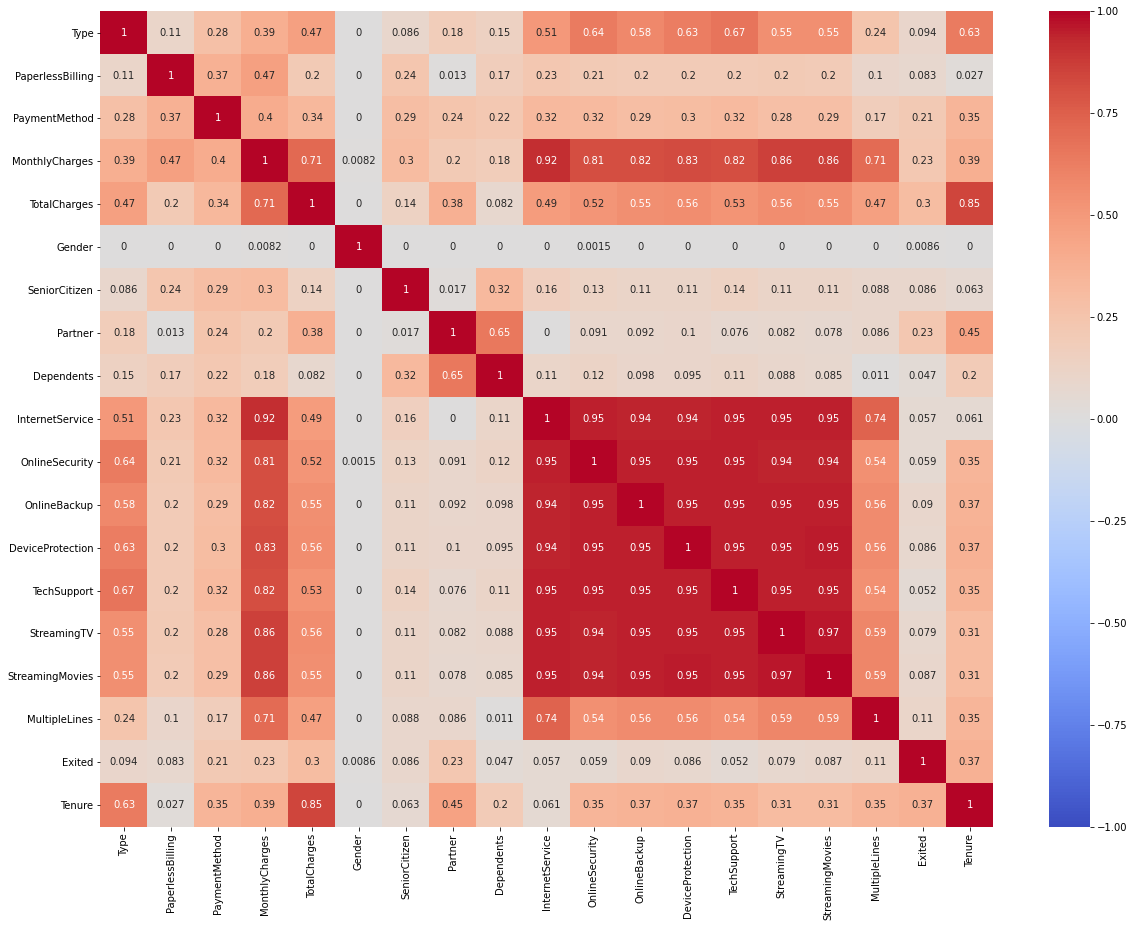

In [ ]:
# построим тепловую карту корреляционной матрицы категориальных признаков
plt.figure(figsize=(20,15))
sns.heatmap(
    data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Tenure']), # матрица корреляции
    #cmap='RdBu_r', # цветовая схема
    #annot=True, # значения внутри ячеек
    cmap='coolwarm', center=0, annot=True,
    vmin=-1, vmax=1);

**Анализ:**

 - корреляция Tenure и BeginDate подразумевалась сразу;
 - зависимость TotalCharges с BeginDate может указывать на наличие у старых пользователей особых привилегий в виде дополнительных скидок на услуги оператора;
 - высокая корреляция типа оплаты Type с BeginDate также может говорить о наиболее распространенных типах оплаты в зависимости от времени подписания договора пользователем услуг оператора;
 - высокая корреляция MonthlyCharges с TotalCharges и колонками услуг тоже вполне очевидна (причем для MultipleLines эта зависимость чуть ниже, а интернет-услуги как правило оплачиваются ежемесячно - это тоже косвенно подтверждается их высокой корреляцией с Type);
 - целевой признак не имеет высоких коэффициентов Пирсона ни с одним другим признаком (больше всего с BeginDate).

### План работ



***Выполненные этапы:***

*- Подготовка данных, в том числе:*

  + *импорт библиотек и данных*
  + *первичная предобработка, включающая в себя объединение таблиц, создание целевого признака, признака длительности и др.изменения столбцов*
  + *исследовательский анализ данных, включающий в себя изучение распределений численных и категориальных признаков, а также анализ корреляционной матрицы с предварительным удалением ненужных столбцов.*

**Дальнейшие действия:**

- Подготовить признаки для моделирования, в том числе:

  * разделить данные на целевой и нецелевые признаки  
  * разделить данные на тестовую и тренировочную выборки (валидационную не обособляем, т.к. будем использовать GS)
  * для разных моделей подготовим разные выборки (потому что кодирование/масштабирование признаков будет реализовано в pipeline)

- Моделирование:

  * выбор моделей, сравнение
  * тестирование лучшей
  * *оценка важности признаков*
  * *анализ матрицы ошибок*.

### Подготовка признаков для моделей

Разделим данные. Целевой признак Exited - факт ухода клиента от оператора.

In [ ]:
# разделение данных на целевой/нецелевые признаки
target = data['Exited']
features = data.drop(['Exited'], axis=1)
# разделение выборок на тренировочную и валидационную в отношении 3:1
f_train, f_test, t_train, t_test = train_test_split(
    features, target, train_size=0.75, random_state=RANDOM_STATE, stratify=target)
# проверка размерностей выборок
for el in (f_train, f_test, t_train, t_test):
    display(el.shape)
# пример
f_train.head()

(5282, 18)

(1761, 18)

(5282,)

(1761,)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Tenure
customerID,,,,,,,,,,,,,,,,,,
2074-GKOWZ,Month-to-month,Yes,Bank transfer (automatic),89.55,461.18,Male,0,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,No,153
3823-KYNQY,One year,No,Credit card (automatic),24.95,299.40,Male,0,No,No,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,Yes,365
6619-RPLQZ,Two year,No,Mailed check,20.85,938.25,Female,0,Yes,Yes,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,1371
5003-OKNNK,One year,No,Credit card (automatic),20.35,335.78,Female,0,Yes,Yes,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,457
6258-NGCNG,Month-to-month,No,Mailed check,23.50,164.50,Male,0,No,No,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,Yes,215


Данные разделили на выборки в заданном проектом соотношении 3:1.

Численные признаки будем масштабировать, а категориальные - кодировать, поэтому подготовим соответствующие списки.
*Заметим, что признак SeniorCitizen является категориальным, несмотря на целочисленный тип, поэтому он должен быть отнесен к соответствующему списку*

In [ ]:
# подготовка списков числовых и категориальных столбцов
numeric = features.select_dtypes(exclude='object').columns.to_list()
categorized = features.select_dtypes(include='object').columns.to_list()
print('Численные столбцы:', numeric,'\nКатегориальные столбцы:', categorized)

Численные столбцы: ['MonthlyCharges', 'TotalCharges', 'Tenure'] 
Категориальные столбцы: ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


Удостоверимся далее, что значения категориальных столбцов в тестовой и тренировочной выборках совпадают, и переведем в тип category категориальные столбцы для использования их в требующих того бустинговых моделях

In [ ]:
#посмотрим на различие в значениях категориальных столбцов тестовой и тренировочной выборок
print('Равенство значений тренировочной и тестовой выборок по категориальным столбцам:')
for col in categorized:
    print(col,(set(f_test[col]) >= set(f_train[col])),
          set(f_test[col]) ^ set(f_train[col]))
# здесь же подготовим выборки для разных моделей
# переопределим выборки для Случайного Леса
f_train_rf = f_train.copy()
f_test_rf = f_test.copy()
# для бустинговых моделей необходимо перевести категориальные данные в тип category
f_train[categorized] = f_train[categorized].astype('category')
f_test[categorized] = f_test[categorized].astype('category')

Равенство значений тренировочной и тестовой выборок по категориальным столбцам:
Type True set()
PaperlessBilling True set()
PaymentMethod True set()
Gender True set()
SeniorCitizen True set()
Partner True set()
Dependents True set()
InternetService True set()
OnlineSecurity True set()
OnlineBackup True set()
DeviceProtection True set()
TechSupport True set()
StreamingTV True set()
StreamingMovies True set()
MultipleLines True set()


/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Предварительные выводы:**

   + Данные разделены на целевой и нецелевые признаки;    
   + Разделены тренировочные и тестовые выборки в заданном проектом соотношении;    
   + Подготовлены списки численных и категориальных столбцов, проверили равенство значений классов в тестовой и тренировочной выборках;    
   + Подготовили выборки отдельно для модели случайного леса и бустинговых моделей
    
Далее переходим к **обучению моделей**

## Моделирование

Обучим разные модели, одна из которых CatBoost, *другая - LightGBM* и не бустинговая RandomForest. Для каждой модели попробуем разные гиперпараметры.

Для оценки качества моделей будем применять метрику AUC-ROC.
Значение метрики AUC-ROC должно быть не меньше 0.85 по условию проекта, эта константа уже объявлена в его начале. Дополнительно отслеживаем значение метрики Accuracy *(для лучшей модели)*.

Модель градиентного бустинга может долго обучаться, поэтому изменим у неё только два параметра.

### Случайный Лес

Гиперпараметры для Случайного Леса будем подбирать через GridSearchCV с Pipeline для масштабирования численных и кодирования категориальных признаков

In [ ]:
## подбор гиперпараметров
# преобразование признаков:
col_transformer_rf = make_column_transformer(
    # категориальные через OHE
    (OneHotEncoder(handle_unknown='ignore'), categorized),#, make_column_selector(dtype_include=object)),#
    # масштабирование через StandardScaler
    (StandardScaler(), numeric)#, make_column_selector(dtype_include=np.number))#
    #remainder='passthrough'#
)

In [ ]:
# задаем модель, формируем пайплайн и определяем гиперпараметры для перебора
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
pipline_rf = make_pipeline(col_transformer_rf, model_rf)
param_grid_rf = {
    'randomforestclassifier__n_estimators': [140],#range(60, 160, 20),#
    'randomforestclassifier__max_depth': [8]#range(2, 15)#
}
# подбор гиперпараметров через RandomizeSearchCV для ускорения процесса
gs_rf = GridSearchCV(
    pipline_rf,
    param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1
)

In [ ]:
%%time
# обучение лучшей модели
gs_rf.fit(f_train_rf, t_train)
tuned_rf = gs_rf.best_estimator_
rf_best_auc_roc = gs_rf.best_score_
rf_best_params = gs_rf.best_params_

CPU times: user 3.63 s, sys: 23.8 ms, total: 3.66 s
Wall time: 3.66 s


    CPU times: user 2min 34s, sys: 753 ms, total: 2min 35s
    Wall time: 2min 35s

In [ ]:
# выводы лучшей модели
print('Best parameters of RandomForestClassifier', rf_best_params)
print('Best AUC-ROC score', round(rf_best_auc_roc,3))

Best parameters of RandomForestClassifier {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 140}
Best AUC-ROC score 0.824


    Best parameters of RandomForestClassifier {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 140}
    Best AUC-ROC score 0.827

### CatBoostClassifier

In [ ]:
# подбор гиперпараметров
model_cb = CatBoostClassifier(cat_features=categorized, random_seed=RANDOM_STATE, verbose=100)
param_grid_cb = {'n_estimators': [220],'depth': [8]} #{'n_estimators': [120,180,220],'depth': [4,8,12]}
gs_cb = GridSearchCV(
    estimator=model_cb,
    param_grid=param_grid_cb,
    scoring='roc_auc', verbose=3)

In [ ]:
%%time
# обучение лучшей модели
gs_cb.fit(f_train, t_train)
tuned_cb = gs_cb.best_estimator_
cb_best_params = gs_cb.best_params_
cb_best_auc_roc = gs_cb.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.076412
0:	learn: 0.6293908	total: 87ms	remaining: 19s
100:	learn: 0.2646702	total: 2.52s	remaining: 2.97s
200:	learn: 0.2038633	total: 5.65s	remaining: 534ms
219:	learn: 0.1924141	total: 6.29s	remaining: 0us
[CV 1/5] END ......................depth=8, n_estimators=220; total time=   7.3s
Learning rate set to 0.076412
0:	learn: 0.6212223	total: 33ms	remaining: 7.24s
100:	learn: 0.2539223	total: 2.43s	remaining: 2.86s
200:	learn: 0.1856648	total: 5.58s	remaining: 527ms
219:	learn: 0.1761678	total: 6.19s	remaining: 0us
[CV 2/5] END ......................depth=8, n_estimators=220; total time=   7.1s
Learning rate set to 0.07642
0:	learn: 0.6285262	total: 32.3ms	remaining: 7.07s
100:	learn: 0.2730080	total: 2.25s	remaining: 2.65s
200:	learn: 0.1983048	total: 5.42s	remaining: 512ms
219:	learn: 0.1875226	total: 6.08s	remaining: 0us
[CV 3/5] END ......................depth=8, n_estimators=220; total time=   7.1s


    CPU times: user 6min 30s, sys: 10.1 s, total: 6min 40s
    Wall time: 7min 24s

In [ ]:
# предсказания и выводы лучшей модели
print('Best parameters of CatBoostClassifier', cb_best_params)
print('Best AUC-ROC score', round(cb_best_auc_roc,3))

Best parameters of CatBoostClassifier {'depth': 8, 'n_estimators': 220}
Best AUC-ROC score 0.859


    Best parameters of CatBoostClassifier {'depth': 8, 'n_estimators': 220}
    Best AUC-ROC score 0.855

### LightGBM

In [ ]:
# подбор гиперпараметров
gs_lg = GridSearchCV(
    estimator=LGBMClassifier(random_state=RANDOM_STATE),
    param_grid={'max_depth': [10], 'n_estimators': [180]}, #{'max_depth': [4,6,10], 'n_estimators': [80,130,180]},
    scoring='roc_auc', verbose=3)

In [ ]:
%%time
# обучение модели с оптимальными гиперпараметрами
gs_lg.fit(f_train, t_train)
tuned_lg = gs_lg.best_estimator_
lg_best_params = gs_lg.best_params_
lg_best_auc_roc = gs_lg.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .................max_depth=10, n_estimators=180; total time=  46.7s
[CV 2/5] END .................max_depth=10, n_estimators=180; total time= 1.0min
[CV 3/5] END .................max_depth=10, n_estimators=180; total time= 1.4min
[CV 4/5] END .................max_depth=10, n_estimators=180; total time=  23.9s
[CV 5/5] END .................max_depth=10, n_estimators=180; total time=  25.0s
CPU times: user 5min 48s, sys: 2.34 s, total: 5min 51s
Wall time: 5min 58s


    Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...................max_depth=4, n_estimators=80; total time= 1.5min
[CV 2/5] END ...................max_depth=4, n_estimators=80; total time= 1.5min
[CV 3/5] END ...................max_depth=4, n_estimators=80; total time= 1.5min
[CV 4/5] END ...................max_depth=4, n_estimators=80; total time= 1.7min
[CV 5/5] END ...................max_depth=4, n_estimators=80; total time= 1.6min
[CV 1/5] END ..................max_depth=4, n_estimators=130; total time= 2.6min
[CV 2/5] END ..................max_depth=4, n_estimators=130; total time= 2.6min
[CV 3/5] END ..................max_depth=4, n_estimators=130; total time= 2.8min
[CV 4/5] END ..................max_depth=4, n_estimators=130; total time= 3.0min
[CV 5/5] END ..................max_depth=4, n_estimators=130; total time= 2.9min
[CV 1/5] END ..................max_depth=4, n_estimators=180; total time= 3.8min
[CV 2/5] END ..................max_depth=4, n_estimators=180; total time= 3.2min
[CV 3/5] END ..................max_depth=4, n_estimators=180; total time= 3.6min
[CV 4/5] END ..................max_depth=4, n_estimators=180; total time= 3.7min
[CV 5/5] END ..................max_depth=4, n_estimators=180; total time= 3.2min
[CV 1/5] END ...................max_depth=6, n_estimators=80; total time= 3.1min
[CV 2/5] END ...................max_depth=6, n_estimators=80; total time= 3.1min
[CV 3/5] END ...................max_depth=6, n_estimators=80; total time= 3.4min
[CV 4/5] END ...................max_depth=6, n_estimators=80; total time= 3.2min
[CV 5/5] END ...................max_depth=6, n_estimators=80; total time= 3.6min
[CV 1/5] END ..................max_depth=6, n_estimators=130; total time= 5.4min
[CV 2/5] END ..................max_depth=6, n_estimators=130; total time= 5.5min
[CV 3/5] END ..................max_depth=6, n_estimators=130; total time= 4.8min
[CV 4/5] END ..................max_depth=6, n_estimators=130; total time= 5.9min
[CV 5/5] END ..................max_depth=6, n_estimators=130; total time= 5.7min
[CV 1/5] END ..................max_depth=6, n_estimators=180; total time= 7.7min
[CV 2/5] END ..................max_depth=6, n_estimators=180; total time= 7.6min
[CV 3/5] END ..................max_depth=6, n_estimators=180; total time= 8.5min
[CV 4/5] END ..................max_depth=6, n_estimators=180; total time= 8.1min
[CV 5/5] END ..................max_depth=6, n_estimators=180; total time= 8.8min
[CV 1/5] END ..................max_depth=10, n_estimators=80; total time= 4.7min
[CV 2/5] END ..................max_depth=10, n_estimators=80; total time= 4.3min
[CV 3/5] END ..................max_depth=10, n_estimators=80; total time= 3.8min
[CV 4/5] END ..................max_depth=10, n_estimators=80; total time= 4.5min
[CV 5/5] END ..................max_depth=10, n_estimators=80; total time= 5.1min
[CV 1/5] END .................max_depth=10, n_estimators=130; total time= 7.5min
[CV 2/5] END .................max_depth=10, n_estimators=130; total time= 7.3min
[CV 3/5] END .................max_depth=10, n_estimators=130; total time= 7.0min
[CV 4/5] END .................max_depth=10, n_estimators=130; total time= 7.2min
[CV 5/5] END .................max_depth=10, n_estimators=130; total time= 7.2min
[CV 1/5] END .................max_depth=10, n_estimators=180; total time= 9.7min
[CV 2/5] END .................max_depth=10, n_estimators=180; total time= 9.1min
[CV 3/5] END .................max_depth=10, n_estimators=180; total time=10.0min
[CV 4/5] END .................max_depth=10, n_estimators=180; total time=10.2min
[CV 5/5] END .................max_depth=10, n_estimators=180; total time=11.0min

    CPU times: user 3h 58min 8s, sys: 2min 23s, total: 4h 31s
    Wall time: 4h 1min 54s

In [ ]:
# сохраним лучшую LGBM-модель
#dump(tuned_lg, 'lgbm_model_of_final_project_1.pkl')
# загрузка лучшей модели из дампа
#tuned_lg = load('lgbm_model_of_final_project_1.pkl')
# значения лучшей модели
lg_best_params = {'max_depth': 10, 'n_estimators': 180}
lg_best_auc_roc = 0.88

In [ ]:
# предсказания и выводы лучшей модели
print('Best parameters of LightGBM', lg_best_params)
print('Best AUC-ROC score', round(lg_best_auc_roc,3))

Best parameters of LightGBM {'max_depth': 10, 'n_estimators': 180}
Best AUC-ROC score 0.88


    Best parameters of LightGBM {'max_depth': 10, 'n_estimators': 180}
    Best AUC-ROC score 0.88

### Вывод

In [ ]:
results = pd.DataFrame(columns=['best_aucroc_score'],
             index=['RandomForestClassifier','CatBoostClassifier','LGBMClassifier'],
             data=[[round(rf_best_auc_roc,3)],
                   [round(cb_best_auc_roc,3)],
                   [round(lg_best_auc_roc,3)]])
results

,best_aucroc_score
RandomForestClassifier,0.824
CatBoostClassifier,0.859
LGBMClassifier,0.880


По значению метрики AUC-ROC на тренировочных данных лучший результат показала модель LGBMClassifier. Проверим ее на тестовых данных.

In [ ]:
best_model = tuned_lg

### Тестирование лучшей модели

In [ ]:
aucroc_best = roc_auc_score(t_test, best_model.predict_proba(f_test)[:,1])
accuracy_best = accuracy_score(t_test, best_model.predict(f_test))
print('Значение AUC-ROC на тестовых данных:',round(aucroc_best,3))
print('Проверка на преодоление минимального порога:', aucroc_best >= AUCROC_MIN)
print('Проверка на отсутствие утечки:', aucroc_best < LEAK)
print('Значение accuracy на тестовых данных', round(accuracy_best,3))

Значение AUC-ROC на тестовых данных: 0.896
Проверка на преодоление минимального порога: True
Проверка на отсутствие утечки: True
Значение accuracy на тестовых данных 0.893


Лучшая модель прошла тест на минимальное значение метрики. Утечки данных не обнаружено. *Метрика Accuracy - точность предсказаний - показывает высокую долю верно предсказанных ответов на тестовых данных, более 89%.* Модель корректно решает задачу классификации.

#### Оценка важности признаков

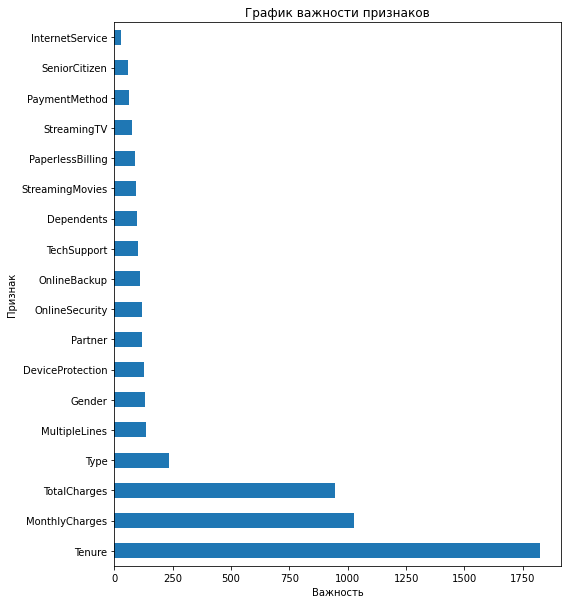

In [ ]:
pd.Series(
    best_model.feature_importances_, index=features.columns
).nlargest(30).plot(kind='barh', figsize=(8,10))
plt.title('График важности признаков')
plt.ylabel('Признак')
plt.xlabel('Важность');

Самыми неинформативными признаками для лучшей модели LightGBMClassifier на основании наших данных являются InternetService (пользуется ли клиент услугой интернета), SeniorCitizen (наличие пенсионного статуса по возрасту) и PaymentMethod (способ оплаты); наиболее важными в порядке возрастания важности являются TotalCharges (общая сумма потраченных денег на услуги), MonthlyCharges (ежемесячные траты по договору), Tenure (длительность пользования услугами оператора клиентом).

Если обратиться снова к корреляционной матрице, то заметим, что Tenure сильно коррелирует с TotalCharges (коэффициент Пирсона 0.85). Это, в свою очередь, не противоречит здравому смыслу, поскольку чем дольше клиент пользуется услугами оператора, тем бОльшая сумма накапливается в итоговую оплату. Возможно, стоит убрать из рассмотрения колонку TotalCharges, исключая избыточные зависимости в погоне за повышением метрики модели (и самые незначимые признаки, озвученные выше, ввиду их неинформативности для модели).

#### Матрица ошибок

In [ ]:
confusion_matrix(t_test, best_model.predict(f_test))

array([[1455,   31],
       [ 157,  118]])

Матрица ошибок показывает количество сочетаний прогнозируемых и фактических значений. Из нашей матрицы ошибок видно, что количество верно предсказанных значений отрицательного класса (истинно-негативные - True Negative, TN) - 1455; ошибочно-позитивных FP (False Positive, ошибки 1-го рода) - 31; ошибочно-негативные FN (ошибки 2-го рода) - 157; истинно-позитивные TP - 118. Метрика Accuracy выражается как отношение:

$Accuracy = (TP+TN)/(TP+TN+FP+FN)$,

т.е. это как раз доля всех правильных ответов от общего количества предсказаний.

*В нашей задаче для клиентов, прекративших пользоваться услугами оператора, значение целевого признака равно 1, иначе - 0, т.е. истинно-положительный ответ — это количество ушедших от оператора клиентов, которые в действительности отказались от пользования услуг.*

Судя по всему, модель хорошо предсказывает истинно-негативные ответы, *т.е. остающихся клиентов,* совершая немного ошибок первого рода *(31 предсказание, что клиент уйдет, но клиент продолжил пользоваться услугами оператора)*. Более чем в 5 раз больше ошибок 2-го рода *(157 раз неверно предсказано, что клиент останется)* и *количество предсказаний* истинно-позитивных ответов *(верно предсказанный уход клиента)* меньше количества ошибок 2-го рода.

*И* поскольку в рамках основной задачи проекта нам необходимо выделить с бОльшей точностью тех, кто собирается уходить от оператора, то такое распределение комбинаций значений *не вполне соответствует ожидаемым верно прогнозируемым уходам клиентов - их всего 118 против 157 потенциальных потерь - клиент уходит, но модель предсказывает обратное. Точность предсказания в рамках интересующего бизнес малого класса (т.н. полнота) около 43%.*

## Отчет

В рамках текущего проекта перед нами стояла **цель** - разработать модель для решения задачи классификации, позволяющую при заданной точности метрики AUC-ROC не более 0.85 прогнозировать уход клиента (для реализации возможности дальнейшего его удержания с помощью промокодов и специальных условий). Для достижения цели необходимо было пройти несколько **ключевых этапов**, все этапы плана были **выполнены**, о них далее.

1. Первым этапом были импортированы необходимые библиотеки, загружены и осмотрены данные, проведена их предобработка.

2. Вторым этапом был проведен исследовательский анализ данных, подготовлены признаки для дальнейших манипуляций.

3. Третьим этапом произведено моделирование: построены три модели, к каждой из которых подобраны оптимальные гиперпараметры для решения основной задачи, выбрана и протестирована лучшая из них.

В процессе выполнения проекта во время осмотра данных на первом этапе было выявлено несколько **проблем с данными**: во-первых, данные изначально представлены в нескольких таблицах; во-вторых, некоторые типы колонок не соответствовали значениям внутри них, а некоторые значения являлись по сути пропусками, но не определялись стандартными средствами; не был определен явно целевой признак, а также не хватало информативных признаков. **В связи с этим** были исправлены типы несоответствующих им колонок, отредактированы "выбивающиеся" значения, созданы дополнительные признаки, в том числе *признак длительности договора* (в дальнейшем для лучшей модели он оказался самым значимым) и целевой *признак ухода клиента* (на основании даты окончания пользования услугами оператора); также данные были соединены в единую таблицу, названия столбцов приведены к единому стилю для удоства обращения с ними. Был проведен анализ баланса классов, определена *задача несбалансированной классификации*.

**В ходе исследовательского анализа** были изучены распределения численных и категориальных данных, произведен анализ корреляций переменных разного типа. Высоких значений зависимости с целевым признаком выявлено не было. Предварительно были *удалены столбцы с датами*, поскольку в рамках нашей задачи их использование при моделировании некорректно. **При подготовке данных для моделирования** были выделены выборки, разделяющие целевой и нецелевые признаки, а также тренировочный и тестовый наборы в заданном проектом соотношении. Также подготовлены списки численных и категориальных столбцов для дальнейшей обработки соответствующих значений (масштабирование численных и кодирование категориальных). Поскольку для выбора лучшей модели использовались три модели - Случайный Лес (RandomForestClassifier) и две бустинговые (CatBoostClassifier и LGBMClassifier), - для них необходимо было подготовить разные типы категориальных столбцов (бустинговые модели требуют определенный формат данных category для категориальных значений). Итоговый список признаков выглядит следующим образом:
    
    Численные столбцы: ['MonthlyCharges', 'TotalCharges', 'Tenure']

    Категориальные столбцы: ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

Поскольку для выбора лучшей модели использовались три модели - Случайный Лес (RandomForestClassifier) и две бустинговые (CatBoostClassifier и LGBMClassifier), - для них необходимо было подготовить разные типы категориальных столбцов: бустинговые модели требуют определенный формат данных category для категориальных значений, а для модели Случайного Леса преобразование признаков произвели с помощью трансформера, в который были включены масштабирование численных с помощью StandardScaler и кодирование категориальных с помощью OneHotEncoder; вся реализация обучения модели Случайного Леса с применением этого трансформера производилась с помощью Pipeline, подбор гиперпараметров всех моделей реализован при помощи GridSearchCV.

**По окончанию обучения** были определены оптимальные гиперпараметры для каждой модели и выявлена лучшая по рассматриваемой метрике AUC-ROC. Ею оказалась модель LightGBM. Данные по всем обученным моделям приведены в таблице.

                     model    best_aucroc_score
                     
    RandomForestClassifier	0.824
        CatBoostClassifier	0.859
            LGBMClassifier	0.880
            
*Лучшая модель* LGBMClassifier имеет параметры {'max_depth': 10, 'n_estimators': 180}, где max_depth - максимальная глубина обучения (10), n_estimators - количество решателей (180). Ее метрика на кроссвалидации равна 0.88. На тестовых данных значение AUC-ROC составило 0.896, что позволило модели преодолеть минимальный порог 0.85, заданный проектом, но не обнаружило утечки данных (best_aucroc < 0.95). Метрика Accuracy, равная 0.893 (точность предсказаний), показывает высокую долю верно предсказанных ответов на тестовых данных более 89%. Модель **корректно решает задачу классификации**.

**Последним этапом** дополнительно оценили *важность признаков* и проанализировали *матрицу ошибок*.

**График важности признаков**:

![%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202023-08-27%20%D0%B2%2018.06.42.png](attachment:%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202023-08-27%20%D0%B2%2018.06.42.png)

Самыми неинформативными признаками для лучшей модели LGBMClassifier на основании наших данных являются InternetService (пользуется ли клиент услугой интернета), SeniorCitizen (наличие пенсионного статуса по возрасту) и PaymentMethod (способ оплаты); наиболее важными в порядке возрастания важности являются TotalCharges (общая сумма потраченных денег на услуги), MonthlyCharges (ежемесячные траты по договору), Tenure (длительность пользования услугами оператора клиентом).

**Матрица ошибок** с наименованиями комбинаций значений (истинность ответа/истинный класс значения):

    TN = 1455, FP = 31,
    FN = 157, TP = 118,
    
где TN - количество истинно-отрицательных предсказаний модели (модель верно предсказала, что клиент не уходит, он в действительности остается клиентом оператора), FN - ложно-отрицательных (модель неверно предсказала, что клиент остается - на самом деле клиент разорвал договор), FP - ложно-положительных (модель предсказывает уход клиента, но он не уходит в дейстительности), TP - истинно-положительных ответов модели (модель верно предсказывает уход).

В рамках основной задачи проекта нам необходимо выделить с бОльшей точностью тех, кто собирается уходить от оператора, поэтому такое распределение комбинаций значений **не вполне соответствует** ожидаемым верно прогнозируемым уходам клиентов: их всего 118 против 157 потенциальных потерь - клиент уходит, но модель предсказывает обратное. Точность предсказания в рамках интересующего бизнес класса около 43%.

**Перспективы развития** проекта:

Несмотря на то, что *цель проекта достигнута (модель корректно решает задачу прогнозирования ухода клиента от оператора в рамках заданных метрикой проекта ограничений)*, для повышения точности модели (особенно в рамках интересующего класса) можно попробовать реализовать ряд некоторых действий.

 - Возможно, стоит **убрать** из рассмотрения колонку TotalCharges, исключая избыточные зависимости в погоне за повышением метрики модели (и самые незначимые признаки, озвученные выше, ввиду их неинформативности для модели).
 - Вместо TotalCharges имеет смысл **добавить** признак AverageCharges, состоящих из фактических средних значений оплаты за день (отношение общей суммы потраченных денег TotalCharges к длительности Tenure).
 - Можно **составить** признак из всевозможных сочетаний столбцов интернет-услуг и убрать сами столбцы с интернет-услугами, или составить таким образом метрику погружённости клиента в компанию: чем больше услуг, тем выше метрика, тем выше лояльность.
 - Можно "прокачать" не ставшие лучшими модели, попробовав **подобрать** бОльшее число гиперпараметров (или попробовать другие).
 - Метрика **Recall** отражает возможность обнаруживать малый класс (который в рамках нашей задачи как раз является наиболее интересным - нам необходимо распознать уходящего клиента), на нее стоит обратить больше внимания.


**Вывод:**

**Цель** проекта разработать модель для решения задачи классификации, позволяющую при заданной точности метрики AUC-ROC не более 0.85 прогнозировать уход клиента, была успешно **достигнута** с помощью модели LGBMClassifier с гиперпараметрами {'max_depth': 10, 'n_estimators': 180}; метрика AUC-ROC на тестовых данных соответствует ограничениям проекта. Дополнительно были предложены рекомендации по повышению точности модели.